<a href="https://colab.research.google.com/github/fatday/STATS-305B-HW4-Group/blob/main/hw4_brainstorm_tokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [2]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

In [3]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [4]:
import re
data_words = re.findall(r'\w+|\s+|[^\w\s]', data)
vocabs_set = sorted(list(set(data_words).union(set(data))))
vocab_size = len(vocabs_set)

In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(vocabs_set) }
itos = { i:ch for i,ch in enumerate(vocabs_set) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
m = len(data_words)
train_chars = data_words[:int(m*0.9)]
val_chars = data_words[int(m*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 419,020 tokens
val has 46,558 tokens


In [6]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B,T,D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5
        #tril = torch.tril(torch.ones(T, T, device=x.device))
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  ## wei.shape:
        out = wei @ v
        return out

In [7]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.context_window_size = context_window_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B, min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [8]:

class MultiHeadAttention(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads  # 确保总维度匹配

        self.heads = nn.ModuleList(
            [Head(self.head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(embed_size * num_heads, embed_size)  # 确保总维度匹配
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # 拼接 heads

        out = self.dropout(self.proj(out))  # 投影回 embed_size
        return out


In [9]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.atten_heads(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B,min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [10]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, dropout = 0.2):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)
        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [12]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384,
                 num_heads=6, n_layers=6, dropout=0.2):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads,
                             dropout=dropout)
            for _ in range(n_layers)])

        # final layer norm

        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.context_window_size = context_window_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = ...
        loss = ...

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        B, T, V = logits.shape
        logits = logits.view(B*T, V)

        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        B, T = token_ids.shape
        context_length = self.position_embedding_table.num_embeddings
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            input_tokens = new_token_sequences[:, max(0,T + t - context_length):T + t]
            logits, loss = self(input_tokens)
            logits = logits.view(B,min(T + t, self.context_window_size), -1)
            logits = logits[:, -1, :] # (B, V)
            probs = F.softmax(logits, dim=-1) # (B, V)
            new_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            new_token_sequences[:, T + t] = new_token.squeeze(-1) # (B, T+1)
        return new_token_sequences

In [13]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 1.4 in around 15 minutes of training on a T4 GPU.

In [14]:
trans = TransformerLM(vocab_size, context_window_size=256,
                      embed_size=512, num_heads=6, n_layers=6, dropout= 0.2)
tlm = trans.to(device)
learning_rate = 1e-5
# TODO, your code below

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate, weight_decay=0.1)

eval_interval = 200

loss_list = []

for it in tqdm(range(LARGE_ITERS+1000)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
      print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 9.4975, val loss 9.5035


  7%|▋         | 200/3000 [00:44<07:44,  6.02it/s]

iteration 200


  7%|▋         | 201/3000 [00:55<2:38:41,  3.40s/it]

step 200: train loss 5.1048, val loss 5.2019


 13%|█▎        | 400/3000 [01:28<07:07,  6.08it/s]

iteration 400


 13%|█▎        | 401/3000 [01:39<2:27:15,  3.40s/it]

step 400: train loss 4.2150, val loss 4.3187


 20%|██        | 600/3000 [02:12<06:36,  6.06it/s]

iteration 600


 20%|██        | 601/3000 [02:23<2:16:00,  3.40s/it]

step 600: train loss 3.8157, val loss 3.9533


 27%|██▋       | 800/3000 [02:56<06:02,  6.07it/s]

iteration 800


 27%|██▋       | 801/3000 [03:07<2:04:34,  3.40s/it]

step 800: train loss 3.6351, val loss 3.7825


 33%|███▎      | 1000/3000 [03:40<05:30,  6.05it/s]

iteration 1000


 33%|███▎      | 1001/3000 [03:50<1:53:16,  3.40s/it]

step 1000: train loss 3.5264, val loss 3.6841


 40%|████      | 1200/3000 [04:23<04:57,  6.05it/s]

iteration 1200


 40%|████      | 1201/3000 [04:34<1:42:02,  3.40s/it]

step 1200: train loss 3.4605, val loss 3.6332


 47%|████▋     | 1400/3000 [05:07<04:24,  6.06it/s]

iteration 1400


 47%|████▋     | 1401/3000 [05:18<1:30:38,  3.40s/it]

step 1400: train loss 3.4132, val loss 3.6002


 53%|█████▎    | 1600/3000 [05:51<03:51,  6.06it/s]

iteration 1600


 53%|█████▎    | 1601/3000 [06:02<1:19:12,  3.40s/it]

step 1600: train loss 3.3808, val loss 3.5683


 60%|██████    | 1800/3000 [06:35<03:17,  6.06it/s]

iteration 1800


 60%|██████    | 1801/3000 [06:46<1:07:58,  3.40s/it]

step 1800: train loss 3.3484, val loss 3.5506


 67%|██████▋   | 1999/3000 [07:19<02:45,  6.05it/s]

iteration 1999


 67%|██████▋   | 2000/3000 [07:29<56:36,  3.40s/it]

step 1999: train loss 3.3338, val loss 3.5308
iteration 2000


 67%|██████▋   | 2001/3000 [07:40<1:34:13,  5.66s/it]

step 2000: train loss 3.3290, val loss 3.5337


 73%|███████▎  | 2200/3000 [08:13<02:11,  6.06it/s]

iteration 2200


 73%|███████▎  | 2201/3000 [08:24<45:13,  3.40s/it]

step 2200: train loss 3.3142, val loss 3.5161


 80%|████████  | 2400/3000 [08:57<01:39,  6.04it/s]

iteration 2400


 80%|████████  | 2401/3000 [09:08<33:54,  3.40s/it]

step 2400: train loss 3.2899, val loss 3.5170


 87%|████████▋ | 2600/3000 [09:41<01:05,  6.08it/s]

iteration 2600


 87%|████████▋ | 2601/3000 [09:52<22:34,  3.39s/it]

step 2600: train loss 3.2686, val loss 3.4962


 93%|█████████▎| 2800/3000 [10:25<00:33,  6.04it/s]

iteration 2800


 93%|█████████▎| 2801/3000 [10:36<11:15,  3.40s/it]

step 2800: train loss 3.2426, val loss 3.4759


100%|██████████| 3000/3000 [11:09<00:00,  4.48it/s]


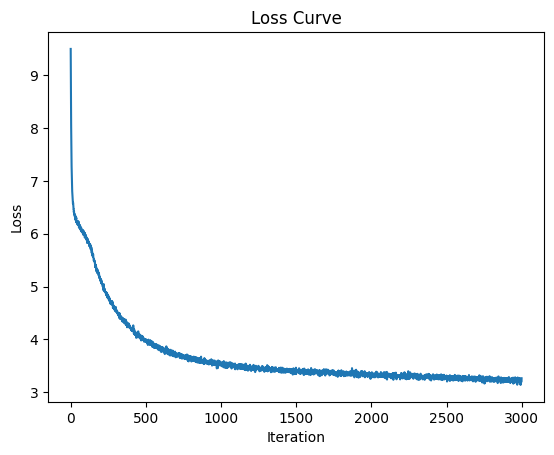

In [15]:
## plot the loss_curve
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

#### Question 1.4.3: Generating text!

Now with our trained model, we can generate some text that is somewhat like the style of Shakespeare! Below we will do both unconditional and conditional generation.

In [18]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(uncond_gen))


ButHASTINGS, rivals I leave noble you, me will Earl not but well:
You a us girls.

HASTINGS:
VOLUMNIA: married was friar his born provost! thenThen,-

DUKE guiltless VINCENTIO:
Why, thou be take back to Moreover,
Even a serpents been denied forgive.

Gardener:
O full spirits 'll in villain,
And to more a thee be her rest himown break obtain
As mewhen come the the of not boy.
Were Sinon, days GREY!

FRIAR this:
spoil but a will he have put profound did Sorrow fashions full father.
They all as example the both meetadvice!
posterity, sobs, award man to hath more our field
distance! how shows cut know due Despite pilot keepnot woman'tis


In [19]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

In [20]:
cond_gen = (tlm.generate(context1_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen))

ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, shame,loud make benefit
businesses deliver them runs what to frame vaultIs long,
held aught and fight; as now,
I kill, revenged farewell, wasteful in been her:
But, little we and make dedicate aching yet bed.
Thou his the be like dedication,
A that budge thou my the like come kindred doth lastly:
With say rest brake a my of this
Which ballad, they to wound with solemn this one;
Art he speak with buildeth our comfort Tullus be:
Than I to danger will newly I shall soldiers:
Show your coming colour's theean: ten tell all vices;
To shall one charitable purest flag soprivileges:
What, in his 'd there as dismal nurse,
That with writ general


TODO: Choose your own context from Shakespeare, and perform conditional generation from that text. Does this look reasonable to you? Why or why not?

In [41]:
# TODO: your code here
my_text_con = """First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.
"""

my_text_target = """MENENIUS: Either you must Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more."""

In [22]:
cond_text_token = encode(my_text_con)
target_text_token = encode(my_text_target)

# transfer back to text
target_text_token_size = len(target_text_token)
cond_text_token_size = len(cond_text_token)

# transfer to torch
cond_text_tokens = torch.tensor(cond_text_token, device=device).reshape(1, -1)

# My Input Text:

In [42]:
print(my_text_con)

First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.



# Target Text

In [43]:
print(my_text_con + "\n" + my_text_target)

First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

MENENIUS: Either you must Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more.


# Text Generated for Target

In [55]:
my_tar_gen = (tlm.generate(cond_text_tokens, max_new_tokens=target_text_token_size)[0].tolist())
my_target_gen_text = decode(my_tar_gen)
print(my_target_gen_text)

First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

MENENIUS: Either you must
solemn pardon, I flight'sbowels me for'swidens toIt eyes.
bear sir arm'fardel, not I forty ancestry
Not rest he sun wilderness, sister:
And truly spirit past here present:
You skirts all me would in me;
In war you, not drunkard to ignorant?
I let should revive not not findings:
When shall amongst this less'd now I fair wakes,
Your worthy said Elbow's his deed died,
Of is misery shall and my me live our poor
How bandying matter souls dust, friends,
He have must religious out, 


In [74]:
intput = """
GONZALO:
That our garments, being, as they were, drenched in
the sea, hold notwithstanding their freshness and
glosses, being rather new-dyed than stained with
salt water.

ANTONIO:
If but one of his pockets could speak, would it not
say he lies?

SEBASTIAN:
Ay, or very falsely pocket up his report.
"""

output = """
GONZALO:
Methinks our garments are now as fresh as when we
put them on first in Afric, at the marriage of
the king's fair daughter Claribel to the King of Tunis.

SEBASTIAN:
'Twas a sweet marriage, and we prosper well in our return.

ADRIAN:
Tunis was never graced before with such a paragon to
their queen.

GONZALO:
Not since widow Dido's time.
"""

In [75]:
intput_tokens = torch.tensor(encode(intput), device=device).reshape(1, -1)

In [77]:
output_token = (tlm.generate(intput_tokens, max_new_tokens=target_text_token_size)[0].tolist())
output_text = decode(output_token)
print(output_text)


GONZALO:
That our garments, being, as they were, drenched in
the sea, hold notwithstanding their freshness and
glosses, being rather new-dyed than stained with
salt water.

ANTONIO:
If but one of his pockets could speak, would it not
say he lies?

SEBASTIAN:
Ay, or very falsely pocket up his report.
attends know I unfeigned this what Jack taketh I sue,
what movehousekeeping sayest Tranio, our what this:
I my gorged'cerns not think with bear and my the by to another.

Stay.

GLOUCESTER:
I oracle, call I retire speak:
dare my am maidens from Gremio;
As eye but tongue predecessors mother's good,JULIET:
A that'll art so this, a but wrong'!!

MENENIUS:
privy seethey know'll me, Caius days
Could poor fly'pregnant? go better Alps,
back'll a great me; new should-
has Margaret'wrenchingare


---
**Answer:** This looks not that reasonable to me, even it generates some content that looks like poetic style, but the output text contains gibberish phrases and does not match or similar to the text in Shakespeare.

Here are some reasons:

**Bad Decoding & Encoding Design**: The decoder and encoder are just the maps between the characters (Aa-Zz and some symbols) and integers; however, character-level tokenization does not capture the structure of words or grammar effectively. These decoding and encoding methods lack the context that word-level or subword tokenization methods provide. This makes it harder for the model to learn meaningful relationships between words, leading to gibberish text generation.

**Inappropriate Model/Text Architecture for Text in Shakespeare**: The text in Shakespeare is very different from the current text we have seen, it has a unique syntax, structure, and vocabulary that a basic model cannot capture. Moreover, the model is too small or too naive to learn the structure of this type of text.

---

#### Question 1.4.4

The negative log-likelihood (averaged per token) we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perplexity is. Why might it be a more intuitive or natual measure to report than negative log-likelihood? Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (Be sure to distinguish betwen `train` and `validation` perplexity. Which of `train` and `val` perplexity is more helpful for understanding your generated samples? Why?). (*Hint: your answer to Question 1.1.6 may be helpful*).

**Answer:**

First we write out the **perplexity**:

$$
\text{perplexity}=\exp(L)=\left[\prod_{t=1}^T p(s[t]\mid \text{context})\right]^{-\frac{1}{T}}=p(s)^{-\frac{1}{T}}=\frac{1}{p(s)^T}
$$

As we can see, when $p(s)$ increase the perplexity decrease and $\text{perplexity} \geq 1$.

Then intuitively we can say perplexity is a measture that can tell how the documents $s$ contents are reasonable, coherent and logically make sense, more precisely it can interpret as how many similar "reasonable" or likely choices on average when predicting the next token in each step.






The reasons this might it be more intuitive or natual measure to report than negative log-likelihood is the numerical space of perplexity is easier to understand. In negative log-likelihood, the values are in negative and log space which is hard to interpret as a measure. However, the perplexity can interpret how many similar "reasonable" or likely choices on average when predicting the next token in each step, so we can have the sense like model prediction' average degree of varying.

**Train & Validation Perplexity**

In [ ]:
# train & validation negative log-likelihood reported
train_nll, val_nll = losses['train'], losses['val']

# perplexity
train_perplexity = torch.exp(train_nll)
val_perplexity = torch.exp(val_nll)

print(f"train perplexity: {train_perplexity}\n")
print(f"validation perplexity: {val_perplexity}\n")

The reported perplexity of the trained model is not make sense, it has considerably effective perplexity score (in both train and validation, and their score are close, difference around 1) which suggests that that the model should be able to generate somewhat coherent and reasonable text. However, the generated sample contains a lot of gibberish phrases, which not make sense. At here the validation perplexity is more helpful for understanding the generated samples as it can tell how the model will behave in unseen context, which is helpful for understanding the quality and coherence of the samples it generates.

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

## Submission Instructions

You will generate two PDFs: one from Part 1, which involves completing this Colab to create a transformer baseline; and one from the mini-project in Part 2, which will be your write-up of no longer than 4 pages. Be sure to include a link to your code for Part 2 somewhere in your writeup.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope and tag your group members. If you complete the assignment individually, submit as usual.